In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import requests 
import eia
import os
import datetime
import json
import requests
import quandl
import plotly.express as px
import panel as pn
from panel.interact import interact
from panel import widgets
from pathlib import Path
import matplotlib.pyplot as plts
import hvplot.pandas 
pn.extension("plotly")

In [4]:
import pandas_datareader as pdr
import matplotlib.pyplot as plt
#Trade USD/JPY 
fx_data = pdr.get_data_yahoo('JPY=X', '2-March-19') 
fx_data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-07-05,107.769997,107.433998,107.579002,107.579002,0.0,107.579002
2020-07-06,107.788002,107.230003,107.352997,107.359001,0.0,107.359001
2020-07-07,107.705002,107.387001,107.573997,107.578003,0.0,107.578003
2020-07-08,107.391998,107.102997,107.264999,107.282997,0.0,107.282997
2020-07-09,107.241997,107.142998,107.197998,107.230003,0.0,107.230003


In [5]:
#Moving average crossover strategy
fx_data['9_SMA'] = fx_data['Close'].rolling(window=9).mean()
fx_data['20_SMA'] = fx_data['Close'].rolling(window=50).mean()

fx_data = fx_data[fx_data['20_SMA'].notna()]

# MA trade calls
Trade_Buy=[]
Trade_Sell=[]
for i in range(len(fx_data)-1):
    if ((fx_data['9_SMA'].values[i] < fx_data['20_SMA'].values[i]) & (fx_data['9_SMA'].values[i+1] > fx_data['20_SMA'].values[i+1])):
        print("Trade Call for {row} is Buy.".format(row=fx_data.index[i].date()))
        Trade_Buy.append(i)
    elif ((fx_data['9_SMA'].values[i] > fx_data['20_SMA'].values[i]) & (fx_data['9_SMA'].values[i+1] < fx_data['20_SMA'].values[i+1])):
        print("Trade Call for {row} is Sell.".format(row=fx_data.index[i].date()))
        Trade_Sell.append(i)

Trade Call for 2019-07-30 is Buy.
Trade Call for 2019-08-01 is Sell.
Trade Call for 2019-09-12 is Buy.
Trade Call for 2020-01-03 is Sell.
Trade Call for 2020-01-15 is Buy.
Trade Call for 2020-01-31 is Sell.
Trade Call for 2020-02-10 is Buy.
Trade Call for 2020-03-04 is Sell.
Trade Call for 2020-03-25 is Buy.
Trade Call for 2020-04-02 is Sell.
Trade Call for 2020-06-01 is Buy.
Trade Call for 2020-06-17 is Sell.
Trade Call for 2020-07-05 is Buy.


/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



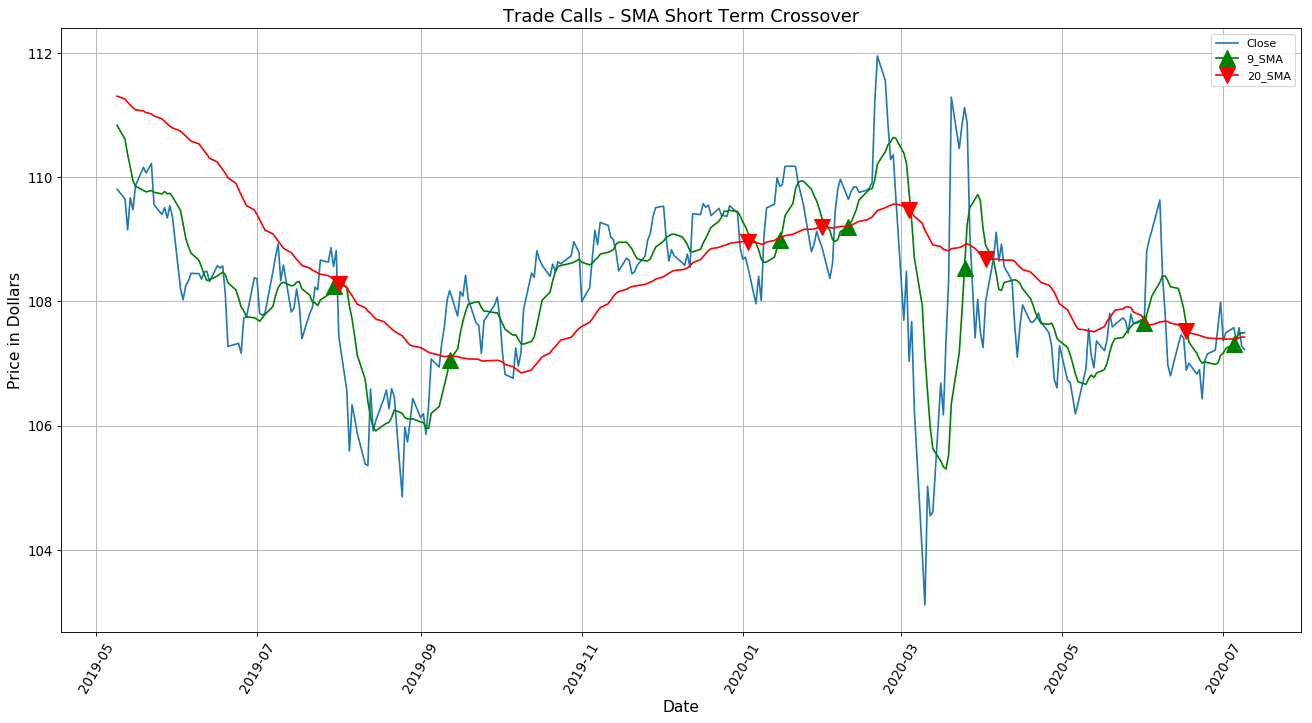

In [6]:
plts.figure(figsize=(20, 10),dpi=80)
plts.plot(fx_data.index, fx_data['Close'])
plts.plot(fx_data.index, fx_data['9_SMA'],'-^', markevery=Trade_Buy, ms=15, color='green')
plts.plot(fx_data.index, fx_data['20_SMA'],'-v', markevery=Trade_Sell, ms=15, color='red')
plts.xlabel('Date',fontsize=14)
plts.ylabel('Price in Dollars', fontsize = 14)
plts.xticks(rotation='60',fontsize=12)
plts.yticks(fontsize=12)
plts.title('Trade Calls - SMA Short Term Crossover', fontsize = 16)
plts.legend(['Close','9_SMA','20_SMA'])
plts.grid()
plts.show() 

In [8]:
#NEWS TRADING STRATEGY 
# News API
url = 'https://newsapi.org/v2/everything?'

# Parameters
parameters = {
    'q': 'USD/JPY', 
    'sortBy': 'popularity', 
    'pageSize': 100,  
    'apiKey': '41f82539f4ec4ba79932a9ce234f115a', 
}

# API request
response = requests.get(url, params=parameters)

# Convert the response to JSON format and store it in dataframe
data = pd.DataFrame(response.json())

news_df = pd.concat([data['articles'].apply(pd.Series)], axis=1)

fx_news = news_df.loc[:,['publishedAt','title']]
fx_news['publishedAt'] = pd.to_datetime(fx_news['publishedAt'])
fx_news.sort_values(by='publishedAt',inplace=True)

# Business day dates
from pandas.tseries.offsets import BDay
# to get the business day for which particular news headline should be used to make trade calls
def get_trade_open(date):
    curr_date_open = pd.to_datetime(date).floor('d').replace(hour=13,minute=30) - BDay(0)
    curr_date_close = pd.to_datetime(date).floor('d').replace(hour=20,minute=0) - BDay(0)
    
    prev_date_close = (curr_date_open - BDay()).replace(hour=20,minute=0)
    next_date_open = (curr_date_close + BDay()).replace(hour=13,minute=30)
    
    if ((pd.to_datetime(date)>=prev_date_close) & (pd.to_datetime(date)<curr_date_open)):
        return curr_date_open
    elif ((pd.to_datetime(date)>=curr_date_close) & (pd.to_datetime(date)<next_date_open)):
        return next_date_open
    else:
        return None
      
 # Trading time for news headlines
fx_news["trading_time"] = fx_news["publishedAt"].apply(get_trade_open)

fx_news = fx_news[pd.notnull(fx_news['trading_time'])]
fx_news['Date'] = pd.to_datetime(pd.to_datetime(fx_news['trading_time']).dt.date)


In [9]:
#NLTK Imports
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [11]:
cs = []
for row in range(len(fx_news)):
    cs.append(analyzer.polarity_scores(fx_news['title'].iloc[row])['compound'])

fx_news['compound_vader_score'] = cs
fx_news = fx_news[(fx_news[['compound_vader_score']] != 0).all(axis=1)].reset_index(drop=True)

fx_news.tail()

,publishedAt,title,trading_time,Date,compound_vader_score
11,2020-06-25 04:21:42+00:00,"Asian markets fall, following Wall Street’s sl...",2020-06-25 13:30:00+00:00,2020-06-25,0.4215
12,2020-06-26 03:46:16+00:00,Asian markets gain after U.S. banks’ stress te...,2020-06-26 13:30:00+00:00,2020-06-26,0.1531
13,2020-06-26 10:45:32+00:00,Why one strategist is actually encouraged by t...,2020-06-26 13:30:00+00:00,2020-06-26,0.3612
14,2020-07-06 04:03:46+00:00,"Asian markets surge, with positive economic da...",2020-07-06 13:30:00+00:00,2020-07-06,0.2023
15,2020-07-09 03:38:05+00:00,Associated Press: Asian markets follow Wall St...,2020-07-09 13:30:00+00:00,2020-07-09,0.5267


In [12]:
unique_dates = fx_news['Date'].unique()
grouped_dates = fx_news.groupby(['Date'])
keys_dates = list(grouped_dates.groups.keys())

max_cs = []
min_cs = []

for key in grouped_dates.groups.keys():
    data = grouped_dates.get_group(key)
    if data["compound_vader_score"].max() > 0:
        max_cs.append(data["compound_vader_score"].max())
    elif data["compound_vader_score"].max() < 0:
        max_cs.append(0)
    
    if data["compound_vader_score"].min() < 0:
        min_cs.append(data["compound_vader_score"].min())
    elif data["compound_vader_score"].min() > 0:
        min_cs.append(0)
    
extreme_scores_dict = {'Date':keys_dates,'max_scores':max_cs,'min_scores':min_cs}
extreme_scores_df = pd.DataFrame(extreme_scores_dict)

In [13]:
final_scores = []
for i in range(len(extreme_scores_df)):
    final_scores.append(extreme_scores_df['max_scores'].values[i] + extreme_scores_df['min_scores'].values[i])

extreme_scores_df['final_scores'] = final_scores

extreme_scores_df.head()

,Date,max_scores,min_scores,final_scores
0,2020-06-09,0.5267,0.0000,0.5267
1,2020-06-10,0.8720,-0.1027,0.7693
2,2020-06-11,0.0000,-0.1027,-0.1027
3,2020-06-12,0.0000,-0.2263,-0.2263
4,2020-06-15,0.0000,-0.3818,-0.3818


In [14]:
# VADER trade calls
vader_Buy=[]
vader_Sell=[]
for i in range(len(extreme_scores_df)):
    if extreme_scores_df['final_scores'].values[i] > 0.20:
        print("Trade Call for {row} is Buy.".format(row=extreme_scores_df['Date'].iloc[i].date()))
        vader_Buy.append(extreme_scores_df['Date'].iloc[i].date())
    elif extreme_scores_df['final_scores'].values[i] < -0.20:
        print("Trade Call for {row} is Sell.".format(row=extreme_scores_df['Date'].iloc[i].date()))
        vader_Sell.append(extreme_scores_df['Date'].iloc[i].date())

Trade Call for 2020-06-09 is Buy.
Trade Call for 2020-06-10 is Buy.
Trade Call for 2020-06-12 is Sell.
Trade Call for 2020-06-15 is Sell.
Trade Call for 2020-06-22 is Sell.
Trade Call for 2020-06-23 is Buy.
Trade Call for 2020-06-25 is Buy.
Trade Call for 2020-06-26 is Buy.
Trade Call for 2020-07-06 is Buy.
Trade Call for 2020-07-09 is Buy.


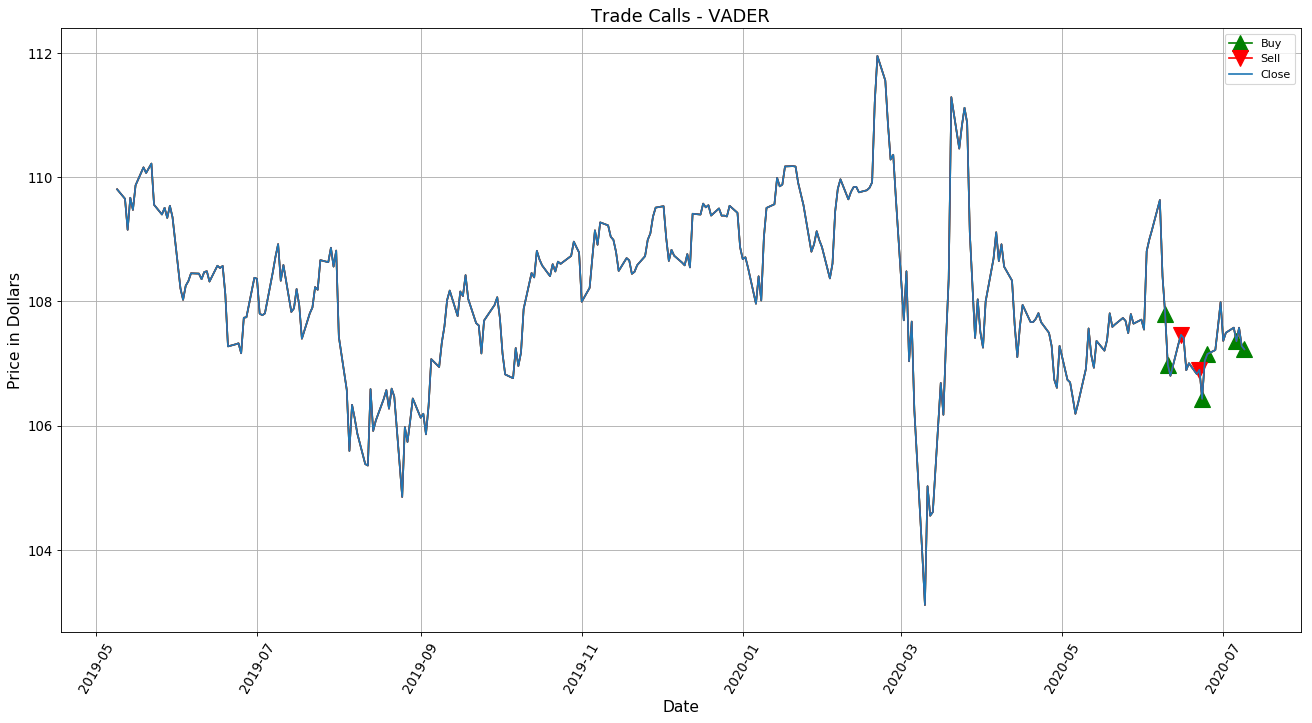

In [16]:
vader_buy = []
for i in range(len(fx_data)):
    if fx_data.index[i].date() in vader_Buy:
        vader_buy.append(i)
        
vader_sell = []
for i in range(len(fx_data)):
    if fx_data.index[i].date() in vader_Sell:
        vader_sell.append(i)
        
plts.figure(figsize=(20, 10),dpi=80)
plts.plot(fx_data.index, fx_data['Close'],'-^', markevery=vader_buy, ms=15, color='green')
plts.plot(fx_data.index, fx_data['Close'],'-v', markevery=vader_sell, ms=15, color='red')
plts.plot(fx_data.index, fx_data['Close'])
plts.xlabel('Date',fontsize=14)
plts.ylabel('Price in Dollars', fontsize = 14)
plts.xticks(rotation='60',fontsize=12)
plts.yticks(fontsize=12)
plts.title('Trade Calls - VADER', fontsize = 16)
plts.legend(['Buy','Sell','Close'])
plts.grid()
plts.show()

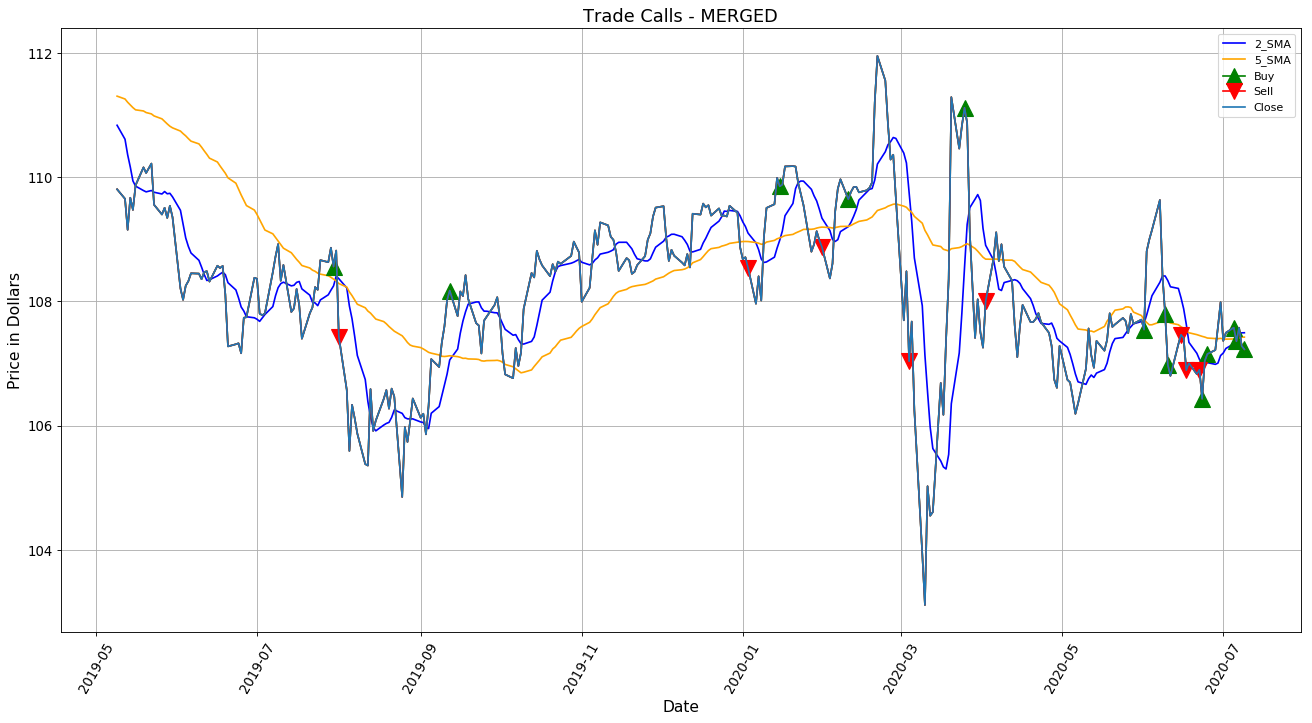

In [18]:
#SMA signals
final_buy = list(set(Trade_Buy + vader_buy) - set(Trade_Sell)) 
final_sell = list(set(Trade_Sell + vader_sell) - set(Trade_Buy))

plt.figure(figsize=(20, 10),dpi=80)
plt.plot(fx_data.index, fx_data['9_SMA'], color='blue')
plt.plot(fx_data.index, fx_data['20_SMA'], color='orange')
plt.plot(fx_data.index, fx_data['Close'],'-^', markevery=final_buy, ms=15, color='green')
plt.plot(fx_data.index, fx_data['Close'],'-v', markevery=final_sell, ms=15, color='red')
plt.plot(fx_data.index, fx_data['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - MERGED', fontsize = 16)
plt.legend(['2_SMA','5_SMA','Buy','Sell','Close'])
plt.grid()
plt.show()